In [3]:
# In [1]
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
# In [2]
df = pd.read_csv('Apple_clean.csv')   # <-- file đã đổi
df.head(10)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-12-31,7.611786,7.619643,7.520000,7.526071,6.326138,352410800
1,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.424604,493729600
2,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.435713,601904800
3,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.333343,552160000
4,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.321635,477131200
5,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.363665,447610800
6,2010-01-11,7.600000,7.607143,7.444643,7.503929,6.307527,462229600
7,2010-01-12,7.471071,7.491786,7.372143,7.418571,6.235778,594459600
8,2010-01-13,7.423929,7.533214,7.289286,7.523214,6.323737,605892000
9,2010-01-14,7.503929,7.516429,7.465000,7.479643,6.287113,432894000


In [5]:
# In [3]
# Nếu có cột 'Date' chuyển về datetime và set làm index
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)


In [6]:
# In [4]
df


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-12-31,7.611786,7.619643,7.520000,7.526071,6.326138,352410800
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.424604,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.435713,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.333343,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.321635,477131200
...,...,...,...,...,...,...
2025-10-23,259.940002,260.619995,258.010010,259.579987,259.579987,32754900
2025-10-24,261.190002,264.130005,259.179993,262.820007,262.820007,38253700
2025-10-27,264.880005,269.119995,264.649994,268.809998,268.809998,44888200


In [7]:
# In [5]
# Select 'Close' column
data = df['Close'].values

# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data.reshape(-1,1))


In [8]:
# In [6]
# Define sizes
train_size = int(len(data_scaled) * 0.7)
val_size = int(len(data_scaled) * 0.1)
test_size = len(data_scaled) - train_size - val_size

# Split
train_data = data_scaled[:train_size]
val_data = data_scaled[train_size: train_size + val_size]
test_data = data_scaled[train_size + val_size : ]

print("Train size:", len(train_data), "Val size:", len(val_data), "Test size:", len(test_data))


Train size: 2787 Val size: 398 Test size: 797


In [9]:
# In [7]
def add_data(data, sequence_length=1):
    X, Y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : (i + sequence_length), 0])
        Y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(Y)


In [10]:
# In [8]
sequence_length = 60

# prepare windows for validation/test so they have preceding context
train_last_windowsize = train_data[-sequence_length:]
# build val_extended: last seq from train + val_data
val_extended = np.concatenate((train_last_windowsize, val_data), axis=0)

# build test_extended: last seq from val_extended's tail + test_data
val_last_windowsize = val_extended[-sequence_length:]
test_extended = np.concatenate((val_last_windowsize, test_data), axis=0)

# Create sequences
X_train, y_train = add_data(train_data, sequence_length)
X_val, y_val = add_data(val_extended, sequence_length)
X_test, y_test = add_data(test_extended, sequence_length)

# reshape to [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# reshape y to (n,1)
y_train = y_train.reshape(-1,1)
y_val = y_val.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, "y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)


X_train shape: (2727, 60, 1) y_train shape: (2727, 1)
X_val shape: (398, 60, 1) y_val shape: (398, 1)
X_test shape: (797, 60, 1) y_test shape: (797, 1)


In [11]:
# In [9]
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# In [10]
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=2)


Epoch 1/50
86/86 - 19s - 218ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 2/50
86/86 - 8s - 92ms/step - loss: 4.4278e-04 - val_loss: 0.0014
Epoch 3/50
86/86 - 8s - 98ms/step - loss: 3.8260e-04 - val_loss: 0.0010
Epoch 4/50
86/86 - 8s - 95ms/step - loss: 2.9885e-04 - val_loss: 0.0010
Epoch 5/50
86/86 - 8s - 98ms/step - loss: 3.2643e-04 - val_loss: 0.0013
Epoch 6/50
86/86 - 8s - 93ms/step - loss: 3.1612e-04 - val_loss: 0.0050
Epoch 7/50
86/86 - 10s - 117ms/step - loss: 2.7775e-04 - val_loss: 0.0014
Epoch 8/50
86/86 - 8s - 92ms/step - loss: 3.0810e-04 - val_loss: 0.0011
Epoch 9/50
86/86 - 10s - 121ms/step - loss: 2.3606e-04 - val_loss: 7.4546e-04
Epoch 10/50
86/86 - 12s - 141ms/step - loss: 2.0931e-04 - val_loss: 0.0013
Epoch 11/50
86/86 - 13s - 155ms/step - loss: 2.0734e-04 - val_loss: 0.0010
Epoch 12/50
86/86 - 9s - 110ms/step - loss: 2.0883e-04 - val_loss: 0.0023
Epoch 13/50
86/86 - 8s - 93ms/step - loss: 2.1248e-04 - val_loss: 9.8020e-04
Epoch 14/50
86/86 - 8s - 90ms/step - loss: 2.

In [13]:
# In [11]
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step  
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [14]:
# In [12]
# Đảm bảo reshape đúng trước khi inverse_transform
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1,1))
y_pred_val_inv = scaler.inverse_transform(y_pred_val.reshape(-1,1))

# Original series (inverse transform scaled arrays) - lưu toàn bộ các phần cần thiết
train_data_inv = scaler.inverse_transform(train_data.reshape(-1,1))
test_data_inv = scaler.inverse_transform(test_data.reshape(-1,1))
val_data_inv = scaler.inverse_transform(val_data.reshape(-1,1))

# Lưu y_test và y_val ở dạng gốc để tính lỗi
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
y_val_inv = scaler.inverse_transform(y_val.reshape(-1,1))


In [15]:
# In [13]
# Metrics on Test set
test_mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
test_mse = mean_squared_error(y_test_inv, y_pred_inv)
test_rmse = np.sqrt(test_mse)
# MSLE: ensure non-negative
test_msle = mean_squared_log_error(y_test_inv.clip(min=0), y_pred_inv.clip(min=0))

print("MAPE on Test set: ", test_mape)
print("RMSE on Test set: ", test_rmse)
print("MSLE on Test set: ", test_msle)

# Metrics on Validate set
val_mape = mean_absolute_percentage_error(y_val_inv, y_pred_val_inv)
val_mse = mean_squared_error(y_val_inv, y_pred_val_inv)
val_rmse = np.sqrt(val_mse)
val_msle = mean_squared_log_error(y_val_inv.clip(min=0), y_pred_val_inv.clip(min=0))

print("MAPE on Validate set: ", val_mape)
print("RMSE on Validate set: ", val_rmse)
print("MSLE on Validate set: ", val_msle)


MAPE on Test set:  0.039931228301364384
RMSE on Test set:  10.986788210211591
MSLE on Test set:  0.0026295749633294696
MAPE on Validate set:  0.03417093969426751
RMSE on Validate set:  6.020049695674746
MSLE on Validate set:  0.0016880009973066843


In [16]:
# In [14]
# Lấy last sequence từ data_scaled (toàn bộ series)
last_sequence_days = data_scaled[-sequence_length:].reshape(1, sequence_length, 1)

y_next_30_days_scaled = []
current_sequence = last_sequence_days.copy()

for i in range(30):
    next_pred_scaled = model.predict(current_sequence)  # shape (1,1)
    y_next_30_days_scaled.append(next_pred_scaled[0,0])
    # cập nhật current_sequence: bỏ đầu + thêm predict
    next_val = np.array(next_pred_scaled).reshape(1,1,1)
    current_sequence = np.concatenate((current_sequence[:,1:,:], next_val), axis=1)

# inverse transform next 30 days
y_next_30_days = scaler.inverse_transform(np.array(y_next_30_days_scaled).reshape(-1,1))
print(y_next_30_days.flatten())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━

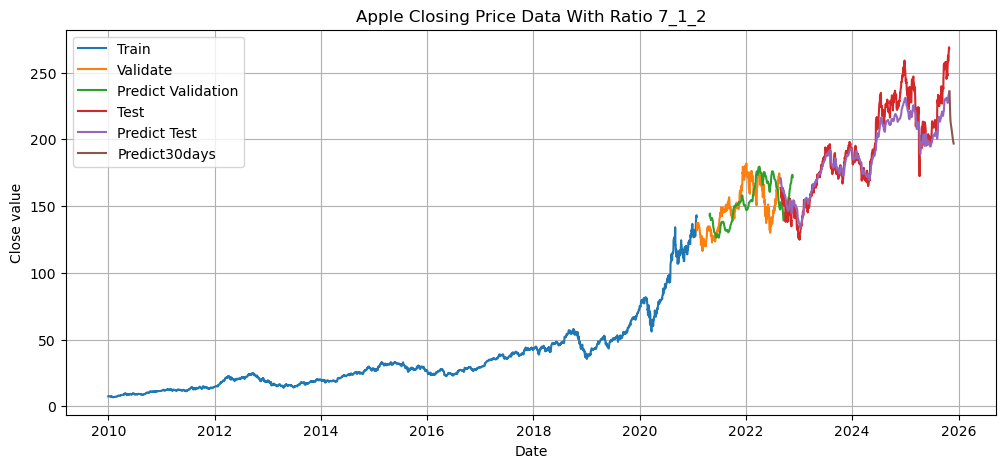

In [17]:
# In [15]
plt.figure(figsize=(12,5))

# Train set plot (use index slices)
plt.plot(df.index[:train_size], train_data_inv, label='Train')

# Validation set (index)
val_index = df.index[train_size: train_size + val_size]
plt.plot(val_index, val_data_inv, label='Validate')

# Predict on validation: need indices aligned to val_index (may be shorter by sequence_length)
pred_val_index = df.index[train_size + sequence_length : train_size + sequence_length + len(y_pred_val_inv)]
pred_val_index = pred_val_index[:len(y_pred_val_inv)]
plt.plot(pred_val_index, y_pred_val_inv.flatten(), label='Predict Validation')

# Test set
test_index = df.index[train_size + val_size : train_size + val_size + len(test_data_inv)]
plt.plot(test_index, test_data_inv, label='Test')

# Predict on test: use last len(y_pred_inv) indices (fix mismatch)
pred_test_index = df.index[-len(y_pred_inv):]
plt.plot(pred_test_index, y_pred_inv.flatten(), label='Predict Test')

# Next 30 days: generate an index starting the day after last df index (if index is datetime)
if isinstance(df.index, pd.DatetimeIndex):
    last_date = df.index[-1]
    index_next_30_days = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
else:
    index_next_30_days = range(len(df), len(df) + 30)

plt.plot(index_next_30_days, y_next_30_days.flatten(), label='Predict30days')

plt.legend(['Train', 'Validate', 'Predict Validation', 'Test', 'Predict Test', 'Predict30days'])
plt.grid()
plt.title("Apple Closing Price Data With Ratio 7_1_2")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('RNN_712_Apple.png')
plt.show()
